## import modules 

In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
import os
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'
from pylab import rcParams
rcParams['figure.figsize']=8,5

## import data

In [2]:
#import data
os.chdir("/home/gladkov/storage/al_R/3new")
os.listdir()
otus = pd.read_csv("otu_table_for_rf.txt", sep="\t")
metadata = pd.read_csv("metadata_for_rf.txt", sep="\t")



In [3]:
# same shit that above with merged repeats
metadata.index = metadata["Unnamed: 0"]
metadata = metadata.drop(columns=["Unnamed: 0"])

otus.index = otus["Unnamed: 0"]
otus = otus.drop(columns=["Unnamed: 0"])

metadata = metadata.drop(columns=["Filename","Description","Plant","Inoculation","Al", "QRTPCR", "SeedCa"])

In [6]:
# Use numpy to convert to arrays
import numpy as np# Labels are the values we want to predict

feature_list = list(metadata)# Convert to numpy array
features = np.array(metadata)
labels = np.array(otus)

In [7]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [8]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (46, 104)
Training Labels Shape: (46, 9971)
Testing Features Shape: (16, 104)
Testing Labels Shape: (16, 9971)


In [10]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = 30)# Fit the random search model
rf_random.fit(train_features, train_labels)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 102 tasks      | elapsed: 15.6min
[Parallel(n_jobs=30)]: Done 300 out of 300 | elapsed: 61.3min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [11]:
rf_random.best_params_

{'n_estimators': 1600,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': True}

In [12]:
rf = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=1600, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
rf.fit(train_features, train_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=1600, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [13]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

random_accuracy = evaluate(rf, test_features, test_labels)

Model Performance
Average Error: 0.2774 degrees.
Accuracy = 92.03%.


In [14]:
# Get numerical feature importances
importances = list(rf.feature_importances_)# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 3)) for feature, importance in zip(feature_list, importances)]# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: SeedMg               Importance: 0.032
Variable: BineMn               Importance: 0.028
Variable: pH                   Importance: 0.019
Variable: SeedS                Importance: 0.019
Variable: BinePerPlantMo       Importance: 0.019
Variable: BineMg               Importance: 0.018
Variable: BineP                Importance: 0.017
Variable: SeedMo               Importance: 0.017
Variable: BineCo               Importance: 0.016
Variable: BineMo               Importance: 0.015
Variable: SeedN                Importance: 0.014
Variable: BineCu               Importance: 0.014
Variable: BineZn               Importance: 0.014
Variable: BineNi               Importance: 0.013
Variable: SeedP                Importance: 0.013
Variable: SoilMn               Importance: 0.013
Variable: BineSeedPerPlantP    Importance: 0.013
Variable: BineM                Importance: 0.012
Variable: Arb                  Importance: 0.012
Variable: NitBine              Importance: 0.012
Variable: NitSeed   

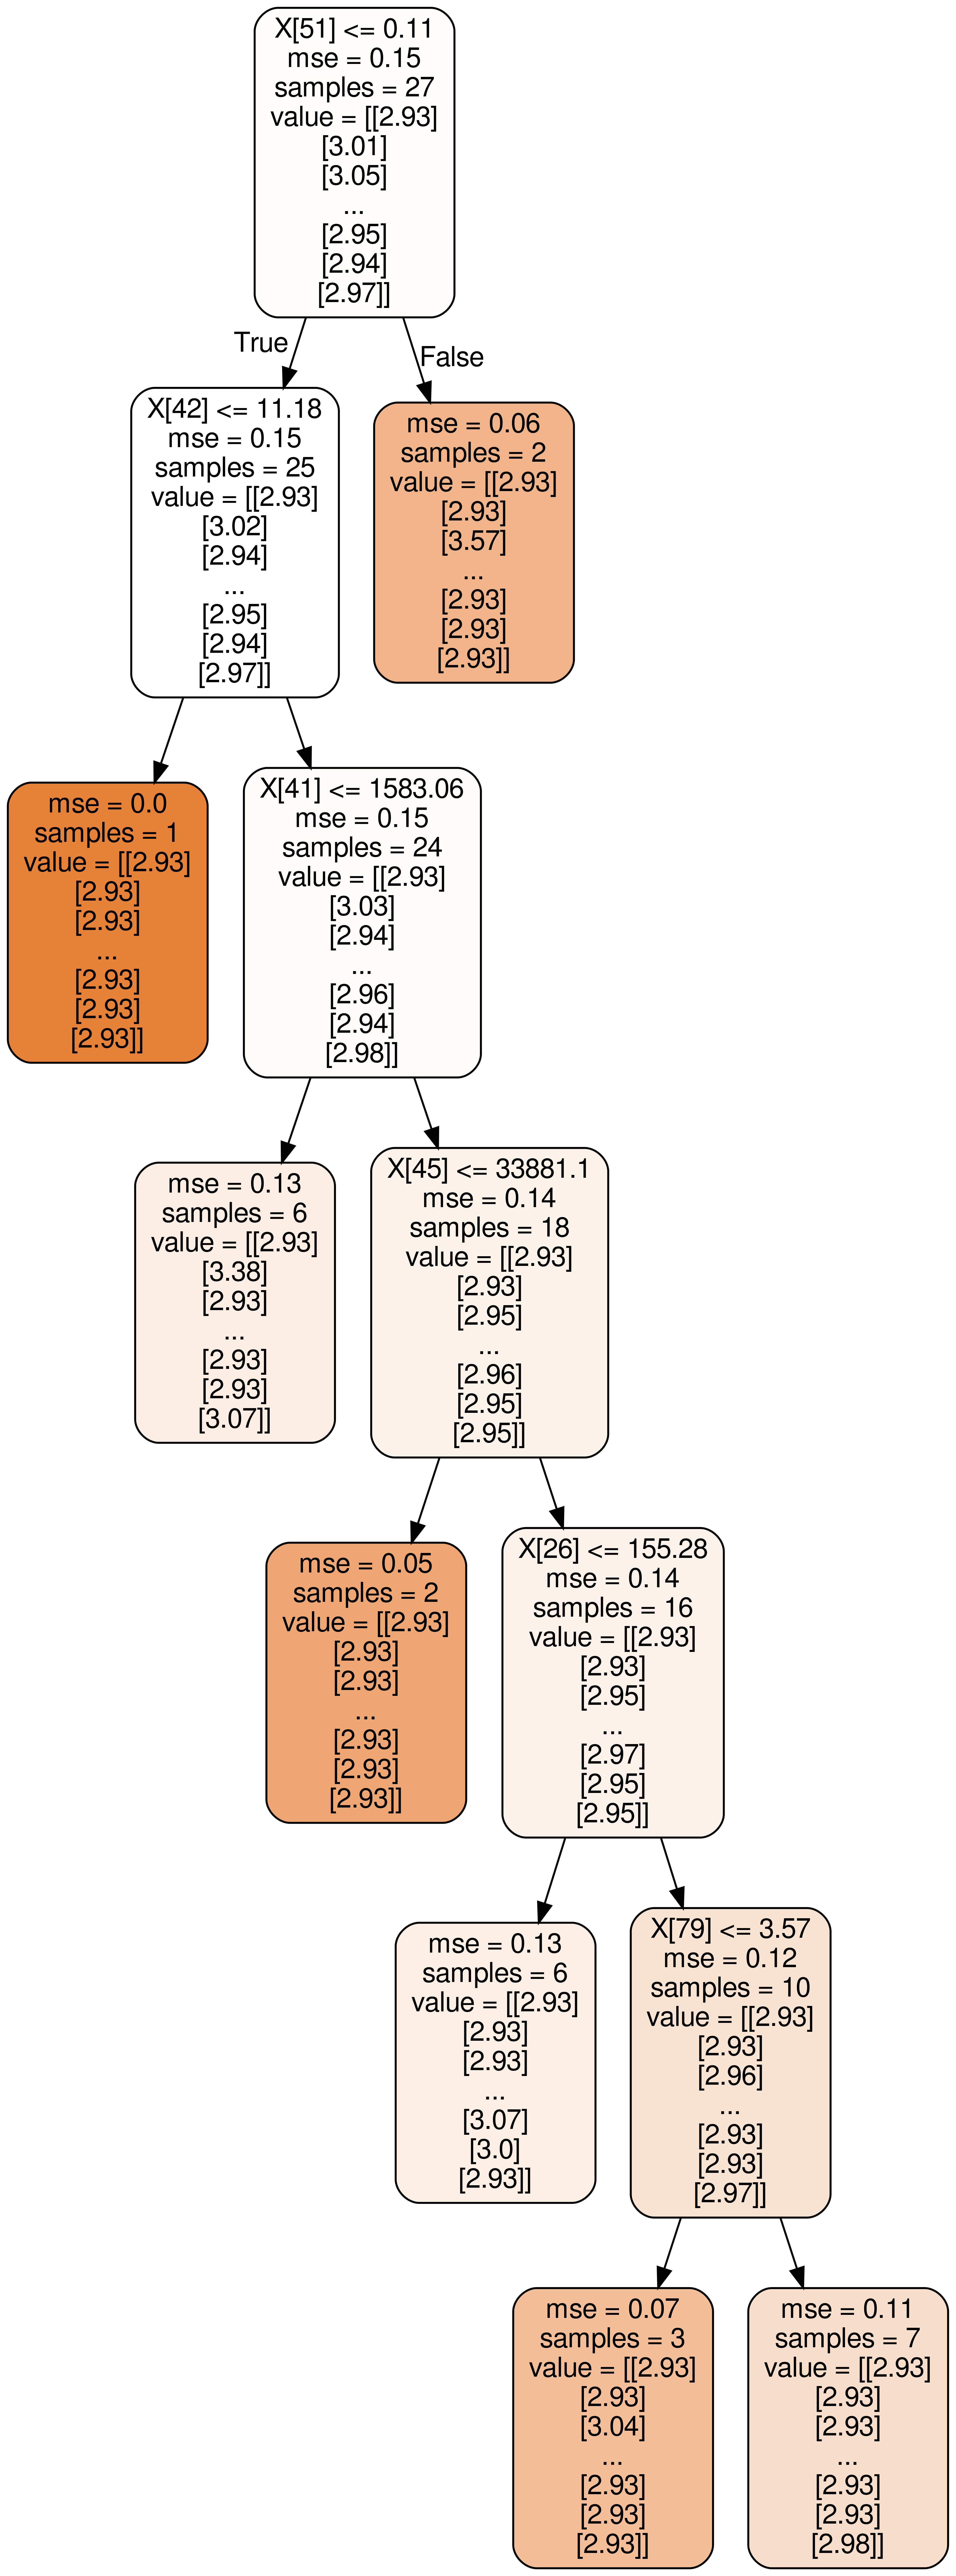

In [18]:
from sklearn.tree import export_graphviz
estimator = rf.estimators_[5]
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')